In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Bernoulli, Normal, Categorical, Dirichlet, Uniform, Multinomial, Empirical
from edward.util import Progbar

Create some sample data:

In [2]:
sample_size = 100
obs_cond = np.random.choice([0,1,2],[sample_size],p=[.7,.1,.2]) # cold = 0, flu = 1, allergies = 2

runny_nose_cold = np.random.choice([0,1],[sample_size],p=[.1,.9])
headache_cold = np.random.choice([0,1],[sample_size],p=[.5,.5])
fever_cold = np.random.choice([0,1],[sample_size],p=[.99,.01])

runny_nose_flu = np.random.choice([0,1],[sample_size],p=[.5,.5])
headache_flu = np.random.choice([0,1],[sample_size],p=[.5,.5])
fever_flu = np.random.choice([0,1],[sample_size],p=[.5,.5])

runny_nose_al = np.random.choice([0,1],[sample_size],p=[.1,.9])
headache_al = np.random.choice([0,1],[sample_size],p=[.99,.01])
fever_al = np.random.choice([0,1],[sample_size],p=[.99,.01])

runny_nose = np.stack([runny_nose_cold,runny_nose_flu,runny_nose_al])
headache = np.stack([headache_cold,headache_flu,headache_al])
fever = np.stack([fever_cold,fever_flu,fever_al])

In [3]:
obs_runny_nose = np.array([runny_nose[j,i] for i,j in enumerate(obs_cond)])
obs_headache = np.array([headache[j,i] for i,j in enumerate(obs_cond)])
obs_fever = np.array([fever[j,i] for i,j in enumerate(obs_cond)])

Hide some of the sample data:

In [4]:
msk_cond = np.ma.masked_where(np.random.rand(sample_size) > .9, obs_cond)
msk_runny_nose = np.ma.masked_where(np.random.rand(sample_size) > .9, obs_runny_nose)
msk_headache = np.ma.masked_where(np.random.rand(sample_size) > .9, obs_headache)
msk_fever = np.ma.masked_where(np.random.rand(sample_size) > .9, obs_fever)

In [5]:
cat_p = Normal(tf.constant([.3,.3,.4]),sigma=tf.ones(3))
cond = Categorical(name='cond', logits=tf.ones([sample_size,3])*cat_p)
    
W = Normal(mu=tf.zeros([3,3]),name='W',sigma=tf.ones([3,3]))
    
runny_nose = Bernoulli(name='runny_nose',logits=tf.gather(W[0,:],cond))
headache = Bernoulli(name='headache',logits=tf.gather(W[1,:],cond))
fever = Bernoulli(name='fever',logits=tf.gather(W[2,:],cond))

In [12]:
num_cond_inferred = sum(np.logical_not(msk_cond.mask))
cond_known = tf.boolean_mask(cond,np.logical_not(msk_cond.mask))
cond_inferred = tf.boolean_mask(cond,msk_cond.mask)


qcondv = Categorical(name='qcondv', logits=tf.Variable(tf.zeros([num_cond_inferred,3],dtype=tf.float32)))
qcat_p = Normal(mu=tf.Variable(tf.zeros(3)),sigma=tf.exp(tf.Variable(tf.zeros(3))))
qW = Normal(mu=tf.Variable(tf.zeros([3, 3])),sigma=tf.exp(tf.Variable(tf.zeros([3, 3]))))


In [14]:

v_inf = ed.KLqp({W:qW,cat_p:qcat_p,cond_inferred:qcondv},
                                {cond_known:msk_cond[np.logical_not(msk_cond.mask)],
                                 runny_nose:obs_runny_nose,
                                 headache:obs_headache,fever:obs_fever})

In [15]:
v_inf.run()

AttributeError: 'Tensor' object has no attribute 'log_prob'

In [9]:
np.mean(tf.sigmoid(qW.sample(100)).eval(),axis=0)

array([[ 0.28244609,  0.38765469,  0.51330596],
       [ 0.70022559,  0.19055055,  0.16891557],
       [ 0.01255861,  0.7646479 ,  0.86940348]], dtype=float32)

In [10]:
msk_cond

masked_array(data = [-- 0 2 0 0 0 0 0 0 0 2 0 0 -- 0 0 0 -- 1 0 0 1 0 1 2 0 0 0 0 0 0 -- 1 0 0
 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -- 1 1 0 1 -- 0 0 1 2 0 0 0 2 2 0 0 --
 0 1 2 0 0 0 2 0 0 -- 0 0 0 0 1 0 1 0 -- 2 0 0 0 0 0 0 1 0 2],
             mask = [ True False False False False False False False False False False False
 False  True False False False  True False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False  True False
 False False False False False False False False False False  True False
 False False False False False False False False  True False False False
 False False False False False  True False False False False False False
 False False False False],
       fill_value = 999999)

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline


0


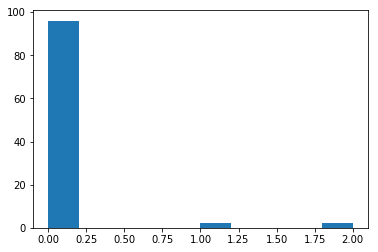

2


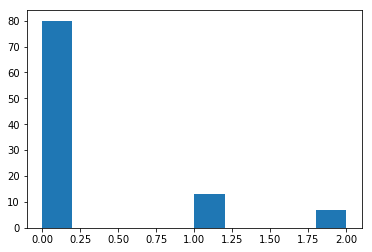

0


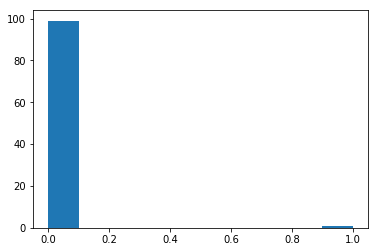

2


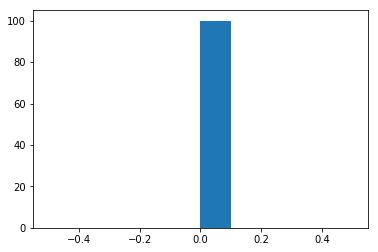

1


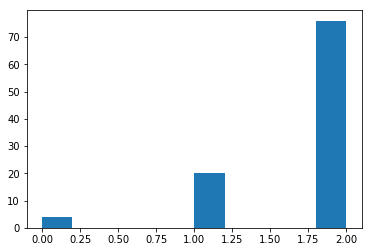

0


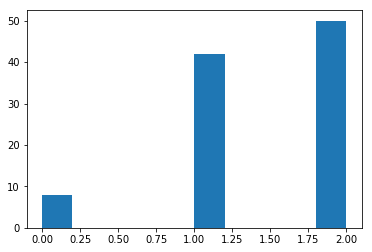

0


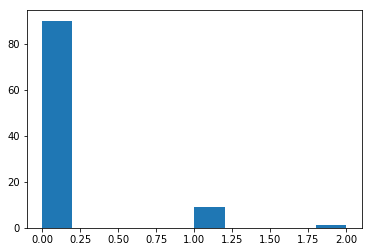

0


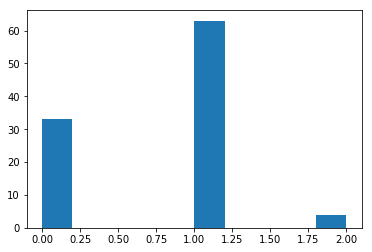

2


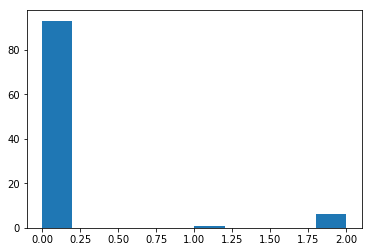

In [33]:
for i,v in enumerate(msk_cond.mask):
    if v:
        print(obs_cond[i])
        plt.hist(qcondv[i].sample(100).eval())
        plt.show()

0


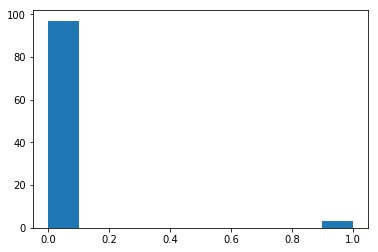

2


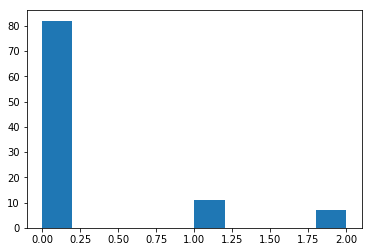

0


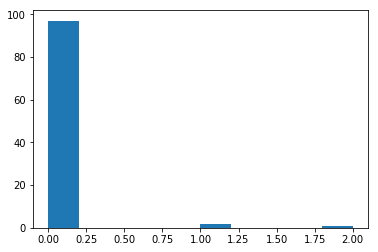

2


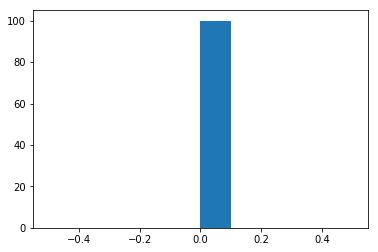

1


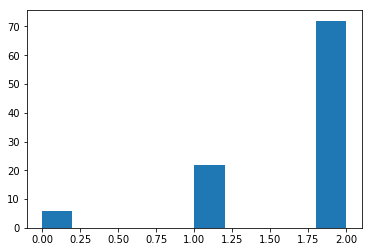

0


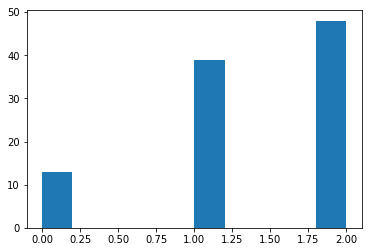

0


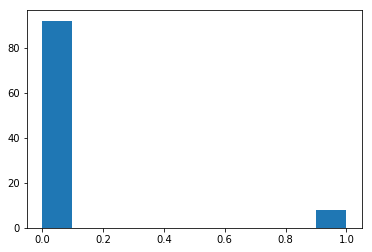

0


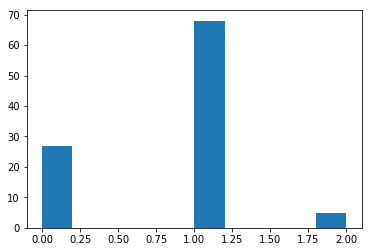

2


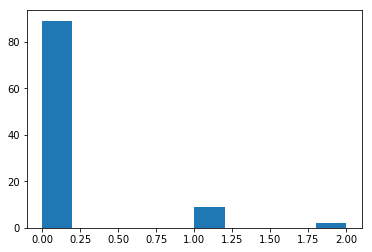

In [34]:
for i,v in enumerate(msk_cond.mask):
    if v:
        print(obs_cond[i])
        plt.hist(qcondv[i].sample(100).eval())
        plt.show()

In [10]:
np.logical_not(msk_cond.mask)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False,  True, False,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,  True], dtype=bool)

In [11]:
sum(msk_cond.mask)

12

In [13]:
msk_cond[np.logical_not(msk_cond.mask)]

masked_array(data = [0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 1 0 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0
 0 2 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 2 0 0 2 0 0 2 2 0 1 2 0 0 2 2 0 0 0 1
 0 0 2 0 0 2 0 0 2 1 0 2 1 0],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False],
       fill_value = 999999)

AttributeError: 'Tensor' object has no attribute 'sample'